# Mask Wearing Detection Model with YOLO v3

최근 코로나 바이러스 사태가 이슈가 되면서 사람들의 마스크 착용이 중요해졌다. 이러한 사태에서 '마스크 착용 여부 탐지 모델'을 개발하면 어떨까 해서 해당 프로젝트를 기획했다. 프로젝트의 목표는 Object Detection 및 YOLO v3 모델의 이해, 그리고 YOLO v3를 활용한 마스크 착용 여부 탐지 모델 개발이다. 프로젝트 과정을 Step으로 나누어 설명하도록 하겠다.

# Step 1: Gathering and Labeling a Custom Dataset

Dataset은 Kaggle에서 제공하는 'Medical Mask Dataset'을 활용하기로 한다. 해당 파일은 총 678개의 이미지와 708개의 labeling xml 파일로 구성되어 있다. 아래 사이트를 통해 Dataset을 확인할 수 있다.<br>
<br>
https://www.kaggle.com/vtech6/medical-masks-dataset

<img src='https://i.postimg.cc/B6XW0M8b/image.png' width='100%'>

Dataset을 모델에 활용할 수 있도록 다음과 같은 프로세스를 거쳤다.<br>
<br>
1. 앞에서 언급했듯이, 마스크 이미지(.jpg, .jpeg, .png)의 수는 678개인데 반해 labeling 파일(.xml)은 708개이다. 각 이미지에 대응하는 labeling 파일의 이름이 같다는 점을 활용하여, 이미지가 존재하지 않는 30개의 .xml 파일을 삭제했다.

2. 대부분의 구현된 모델들은 txt 형식으로 labeling 파일을 읽도록 구현되어있다. 따라서 반정형 데이터인 .xml 파일들을 정형데이터인 .txt 파일로 바꿔주었다. 아래 github repository를 활용하여 작업을 진행했다.

3. 678개의 .xml 파일 중 하나의 파일이 잘못 labeling되어있다. 특정 Object에 대하여 xmin, ymin, xmax, ymax 값이 모두 0으로 기록되어있다. 따라서 해당 이미지와 .xml 파일을 지워, 총 677개의 dataset을 활용한다.

https://github.com/Isabek/XmlToTxt

### .xml 파일

<img src='https://i.postimg.cc/7ZB53Ftb/image.png' width='100%'>

### .txt 파일

<img src='https://i.postimg.cc/k4SDdBJt/image.png' width='100%'>

.xml 파일을 .txt 파일로 변환하면 위와 같은 결과를 확인할 수 있다. .xml 파일을 살펴보면, \<object\> 태그를 통해 하나의 이미지 안에 2개의 BBox가 존재함을 확인할 수 있다. 각 BBox는 class name, BBox의 xmin, ymin, xmax, ymax 정보를 가지고 있다. 이를 변환하여 .txt 파일을 저장하면 된다. class name을 one-hot encoding된 값으로 바꾸고, xmin, ymin, xmax, ymax를 x, y, width, height 값으로 바꿔준다. 이 때 x, y는 BBox의 중심 좌표를 의미하고, width는 BBox의 가로 길이, height는 BBox의 세로 길이를 의미한다. 이들은 모두 전체 이미지에 대한 BBox의 상대적 비율값을 의미한다.<br>
특히 Medical Mask Dataset은 good, bad, none의 3가지 class를 가지고 있다. 따라서 good은 0으로, bad는 1로, none은 2로 labeling된다.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd /content/gdrive/My\ Drive/Project/YOLO\ v3

/content/gdrive/My Drive/Project/YOLO v3


In [0]:
!unzip ../mask_dataset.zip -d /content/gdrive/My\ Drive/Project/YOLO\ v3/darknet/data/obj/

Archive:  ../mask_dataset.zip
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/-1x-1.jpg  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/-1x-1.txt  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/-I1-MS09uaqsLdGTFkgnS0Rcg1mmPyAj95ySg_eckoM.jpeg  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/-I1-MS09uaqsLdGTFkgnS0Rcg1mmPyAj95ySg_eckoM.txt  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/0002526673.jpg  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/0002526673.txt  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/0009S6815V3PEU1N-C123-F4.jpg  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/0009S6815V3PEU1N-C123-F4.txt  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/000_1OC3DT.jpg  
  inflating: /content/gdrive/My Drive/Project/YOLO v3/darknet/data/obj/000_1OC3DT.txt  
  inf

이미지와 라벨링 파일을 한꺼번에 구글드라이브에 올리려면 시간이 너무 오래 걸린다. 따라서 나는 위와 같은 방법을 사용했다. 먼저 이미지와 라벨링 파일을 모두 압축파일로 만든 뒤, 압축파일을 구글드라이브에 업로드한다. 이후 Google Colab 상에서 경로를 지정하여 압축파일을 푼다. 이 방법은 시간을 굉장히 단축할 수 있다. 위의 경로에 압축을 푼 이유는, 차후 모델을 사용할 때 datatset이 저장된 경로를 위의 경로로 설정했기 때문이다.<br><br>
참고로 위의 경로는 아래에서 설명할 github repository를 clone한 뒤에 생기는 경로이다. 설명상의 편의를 위해 unzip 과정을 해당 과정에서 먼저 언급했다.

### Dataset 구성

<img src='https://i.postimg.cc/sXGKd9G9/image.png' width='100%'>

최종적으로 얻은 677개의 이미지와 677개의 .txt 파일을 하나의 폴더에 저장한다. 그 결과 위와 같이 동일한 이름으로 이미지 파일과 .txt 파일이 매칭되어 저장됨을 확인할 수 있다.

# Step 2: Cloning and Building Darknet

여러 Object Detection 모델 중에서 YOLO v3를 활용하기로 한다.<br>
이유는<br>
첫 번째, 마스크 착용 여부 탐지를 위해서는 모델을 real-time이 가능하도록 해야 한다. 따라서 two-stage 작동 방식의 R-CNN 계열 모델보다 one-stage 계열 작동 방식의 YOLO 계열의 모델을 선택했다. 일반적으로 one-stage 계열의 모델은 two-stage 계열의 모델보다 정확도는 낮지만 속도는 빠른 것으로 알려져 있다.<br>
두 번째, 성능이 좋은 모델이면서 자료가 많은 버전을 선택해야 한다. 따라서 YOLO 모델의 여러 버전 중에서 YOLO v3를 선택했다. 참고로 최근에 YOLO v4 모델까지 나온 상태이다.<br>
<br>
특히 구현되어있는 여러 YOLO v3 모델 중에서 AlexeyAB의 github repository를 활용했다. 해당 repository는 Darknet을 기반으로 구현되어있으며 Google Colab 환경에서 사용할 수 있도록 변형되어있다. 이는 아래 사이트를 통해 확인할 수 있다.

https://github.com/AlexeyAB/darknet

In [0]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13567 (delta 1), reused 1 (delta 0), pack-reused 13559
Receiving objects: 100% (13567/13567), 12.20 MiB | 8.90 MiB/s, done.
Resolving deltas: 100% (9256/9256), done.
Checking out files: 100% (2005/2005), done.


In [0]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/gdrive/My Drive/Project/YOLO v3/darknet


Google Colaboratory 환경에서 해당 작업을 수행하기위해 위와 같이 설정을 맞춰준다. 참고로 Google Colab은 GPU 1대를 지원한다.

In [0]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
# make darknet (build)
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_res’ [-Wunused-variable]
     int it_tb_

# Step 3: Download pretrained YOLOv3 weights

YOLO v3가 학회에서 발표되었을때 이미 80개의 class를 가지고 있는 COCO dataset에 학습을 시켜놓았다. 따라서 해당 pretrained weights를 사용하여 모델을 custom dataset에 transfer learning 하는 방향으로 프로젝트를 수행했다.

In [0]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-05-26 12:58:13--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   176KB/s    in 20m 50s 

2020-05-26 13:19:05 (194 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [0]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

Google Colab은 OpenCV를 통해 모델에서 출력된 이미지를 열 수 없다. 따라서 imShow 함수를 정의함으로써, 모델에서 출력된 이미지를 저장한 뒤에 matplotlib을 활용하여 이미지를 열 수 있다.

# Step 4: Run Detections with Darknet and YOLOv3

모델을 transfer learning 하기 전에, 모델이 정상적으로 작동하는지 확인해보겠다. object detector는 다음 명령어를 통해 사용할 수 있다.

```bash
!./darknet detect <path to config> <path to weights> <path to image>
```
* \<path to config\> : 모델의 설정값들이 저장되어 있는 configuration 파일의 경로
* \<path to weights\> : 모델에 사용할 가중치 경로
* \<path to image\> : 모델에 적용할 이미지 경로
<br><br>

object detector를 통해 가장 최근에 출력된 이미지는 'predictions.jpg'로 저장되도록 구현되어있다. 따라서 다음과 같은 명령어를 통해 출력된 이미지를 확인할 수 있다.

```bash
imShow('predictions.jpg')
```
<br>
또한 predictions.jpg가 생성되면 이는 Google Colab이라는 가상머신 또는 지정한 구글드라이브 경로에 저장되어 있는 상태이다. 이미지를 로컬에 저장하고 싶으면 다음과 같은 명령어를 사용할 수 있다.

```bash
download('predictions.jpg')
```

In [0]:
# run darknet detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

참고로 나는 월간 구독을 통해 Google Colab pro를 사용한다. 이는 위의 출력값에서 GPU: Tesla P100-PCIE-16GB 를 할당받는 것을 확인할 수 있다. 개인적으로 같은 코드를 실험해본 결과, 체감상 일반 Google Colab보다 Google Colab pro가 1.3배 정도 더 빠르다.

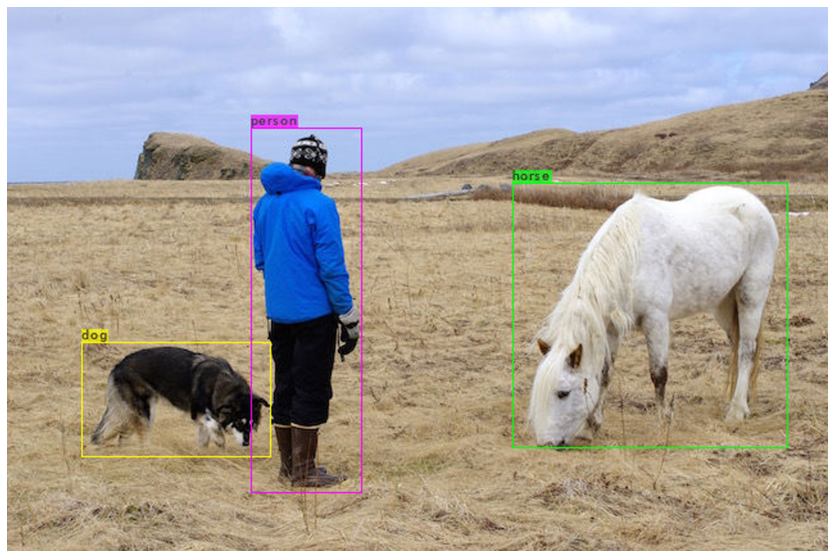

In [0]:
# show image using our helper function
imShow('predictions.jpg')

위의 이미지와 같이 모델이 정상적으로 작동하는 것을 확인할 수 있다. 위의 사진에서는 dog, person, horse를 탐지하는 것을 확인할 수 있다. 이에 대해서 언급하자면, 모델에 적용한 config 파일과 weights가 해당 물체들을 탐지하도록 만들었기 때문에 위와 같은 결과를 도출할 수 있다. 무슨 말이냐면, 만약 COCO dataset에 dog, person, horse가 없다면 학습된 모델은 해당 물체들을 탐지할 수 없다. 즉, config 파일은 내가 해결하고자 하는 문제에 적합하도록 class의 수를 조정하는 역할을 해주고, weights 파일은 조정된 모델이 custom dataset에 학습된 가중치를 의미한다.<br>
내가 해결하고자 하는 문제는 '마스크 착용 여부'를 탐지하는 것이다. 따라서 내가 원하는 모델은 '마스크를 착용한 사람'과 '마스크를 착용하지 않은 사람'을 탐지하는 모델이다. 이에 따라 config를 설정하고, 모델을 transfer learning하여, weights를 얻어야 한다.

[Errno 20] Not a directory: 'darknet'
/content/gdrive/My Drive/Project/YOLO v3/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 -> 

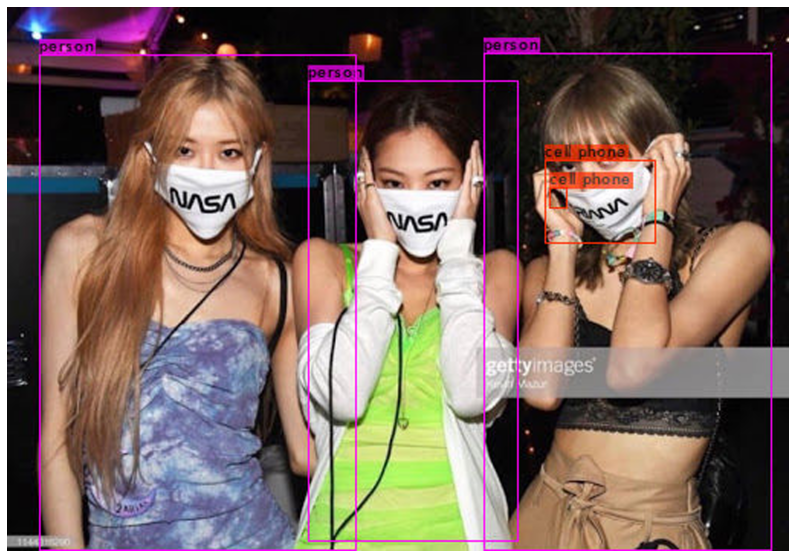

In [0]:
# run darknet command with google drive image (my image path is /images/plane.jpg)
%cd darknet
!./darknet detect cfg/yolov3.cfg yolov3.weights ../blackpink_mask.jpg
imShow('predictions.jpg')

그렇다면 COCO dataset으로 pre-trained된 모델은 마스크를 인식할 수 있을까? 마스크를 인식하려면 COCO dataset의 80개 class 중에 마스크가 포함되어야 하지만 실제로는 해당하지 않는다. 따라서 위와 같이 마스크를 착용한 사람의 이미지를 COCO dataset으로 pre-trained된 모델에 집어넣으면 마스크를 인식하지 못한다. 오히려 가장 오른쪽 사진을 보면 마스크를 80개의 class 중에 그나마 비슷하게 생긴 cell phone으로 잘못 인식하는 결과를 확인할 수 있다.<br>
따라서 마스크의 착용 여부를 labeling 한 custom dataset을 모델에 transfer learning 하여 마스크의 착용 여부만 탐지할 수 있는 모델을 만들어야 할 것이다.

# Step 5: Configuring Files for Training

모델을 custom dataset에 transfer learning 하기 위해서는 몇 가지 설정들이 필요하다. 설정해주어야 할 파일들은 다음과 같다.<br>

* .cfg file
* obj.data
* obj.names
* train.txt

## 1) .cfg file

yolov3.cfg 파일을 복사하여 해결하고자 하는 문제에 맞게 수정한 후 yolov3-custom.cfg로 다시 저장한다. 수정한 사항은 다음과 같다.<br>

* max_batches = 10000
* steps = 8000, 9000
* classes = 3 in the three YOLO layers
* filters = 24 in the three convolutional layers before the YOLO layers
<br><br>

이 때, filters = 24인 이유는 YOLO v3 모델의 작동원리 때문인데, (x, y, w, h, p0, c1, c2, c3)으로 구성된 BBox가 3개 존재하기 때문에 8x3 = 24개의 filters를 갖는다.

<img src='https://i.postimg.cc/G2k8yqBp/image.png' width='100%'>

## 2) obj.names and obj.data

obj.names 파일을 만들어서 class의 종류들을 입력한다.<br>
obj.data 파일을 만들어서 class의 수, obj.names 파일의 경로, dataset 경로, backup 폴더 경로를 입력한다. 모델을 학습한 후의 weights는 설정한 backup 폴더에 저장된다.<br>
생성한 두 개의 파일은 data 폴더에 넣어주었다.

<img src='https://i.postimg.cc/3rkp1CPn/image.png' width='100%'>

<img src='https://i.postimg.cc/8cv7SwGG/image.png' width='100%'>

여기서 주의할 점이 하나 있다. 위의 backup 경로를 보면 일반적인 구글드라이브 경로와는 조금 다르다. 일반적인 구글드라이브 경로는 /content/gdrive/My Drive/ 와 같은 방법으로 접근한다. 그런데 'My Drive'의 space(띄어 쓰기) 때문에 모델을 사용할 때 에러를 일으킨다. 따라서 다음과 같은 코드를 사용하여 /content/gdrive/My Drive/라는 경로를 /mydrive와 같은 경로로 만들어준다.

In [0]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

## 3) train.txt

마지막으로 모델을 학습할 이미지의 경로를 모두 담고 있는 train.txt 파일을 생성한다. 아래 github repository를 참조하여 generate_train.py를 생성했다. 기존 파일은 .jpg 파일에 한해서 경로를 만들어주기 때문에 .jpeg, .png 파일에 대한 경로도 만들어주도록 코드를 수정했다.

https://github.com/theAIGuysCode/YoloGenerateTrainingFile

In [0]:
!python generate_train.py

In [0]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


<img src='https://i.postimg.cc/x1vFCS5J/image.png' width='100%'>

# Step 6: Download pre-trained weights for the convolutional layers

convolutional layers를 위한 pre-trained weights를 다운로드하여 transfer learning을 수행한다. 이는 여러 자료들을 살펴보면서 해당 weights를 통해 모델을 학습하는 것이 정확도가 높고 학습속도도 빠르다는 것을 확인했다. 물론 다른 weights를 사용해도 된다.

In [0]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2020-05-26 16:10:53--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   153KB/s    in 18m 7s  

2020-05-26 16:29:02 (146 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# Step 7: Train My Custom Object Detector

이제 모든 준비는 끝났다. 모델을 custom dataset에 학습시키는 과정은 다음과 같은 코드를 통해 수행할 수 있다.
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```

**TIP**<br>
Google Colab은 30~90분 정도 활동이 없으면 자동적으로 세션을 종료시켜버린다. 학습 도중 이를 방지하기 위해 (CTRL + SHIFT + i)를 통해 창을 띄워 Console 창에 아래 코드를 입력해준다.
```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```
<img src='https://i.postimg.cc/Qxsfyzhj/image.png' width='100%'>

In [0]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3-custom.cfg darknet53.conv.74 -dont_show

<img src='https://i.postimg.cc/L4Vtn8FM/image.png' width='100%'>

<img src='https://i.postimg.cc/k4vb6fZy/image.png' width='100%'>

<img src='https://i.postimg.cc/yYM8K0p6/image.png' width='100%'>

총 10시간에 걸쳐 모델 학습을 마쳤다. backup 폴더에는 1000 epoch 별 weights 파일, 모든 학습을 마친 후의 weights 파일이 저장되어있다. 출력창이 너무 길어서 마지막 epoch 부분만 따로 스크린샷을 하여 위에 표시해두었다.

다음 코드를 통해 모델의 학습 곡선을 확인할 수 있다. 이는 iteration 별 average loss를 보여준다. 모델 제공자는 학습된 모델이 좋은 성능을 내기 위해서는 loss 값이 2 아래로 가는 것을 목표로 해야 한다고 언급한다. 따라서 내가 학습한 모델은 좋은 성능을 낼 것이라고 기대할 수 있다.

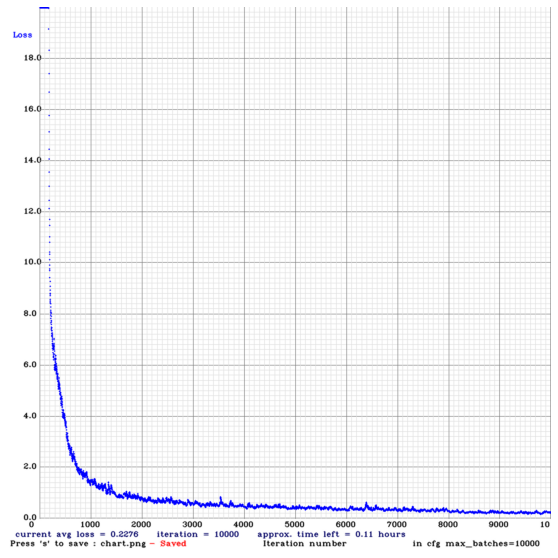

In [0]:
imShow('chart.png')

# Step 8: Run My Custom Object Detector

In [0]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3-custom.cfg
%cd ..

/content/gdrive/My Drive/Project/YOLOv3/darknet/cfg
/content/gdrive/My Drive/Project/YOLOv3/darknet


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

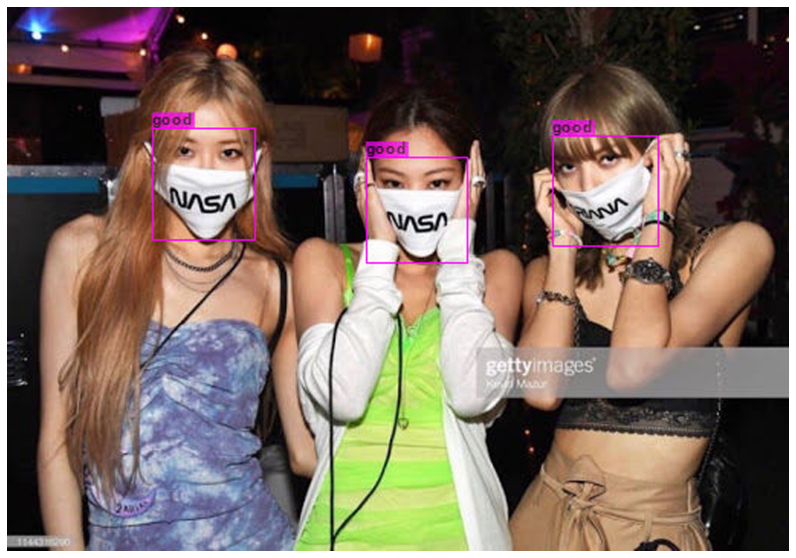

In [0]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3-custom.cfg /content/gdrive/My\ Drive/Project/YOLOv3/darknet/backup/yolov3-custom_last.weights /content/gdrive/My\ Drive/Project/YOLOv3/blackpink_mask.jpg -thresh 0.3
imShow('predictions.jpg')

Step 4에서 COCO dataset에 pre-trained된 모델에 적용했던 이미지를 다시 한 번 적용시켜보았다. 그 결과 위의 이미지처럼 마스크 착용 여부만을 감지하는 것을 확인할 수 있었다.